In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_list = []
filename_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/ws23_processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/ws23_processed_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['resistance_depth_15.csv', 'resistance_depth_36.csv', 'resistance_depth_50.csv', 'resistance_depth_54.csv', 'resistance_depth_25.csv', 'resistance_depth_69.csv', 'resistance_depth_67.csv', 'resistance_depth_46.csv', 'resistance_depth_1.csv', 'resistance_depth_49.csv', 'resistance_depth_45.csv', 'resistance_depth_4.csv', 'resistance_depth_44.csv', 'resistance_depth_59.csv', 'resistance_depth_64.csv', 'resistance_depth_0.csv', 'resistance_depth_21.csv', 'resistance_depth_71.csv', 'resistance_depth_53.csv', 'resistance_depth_20.csv', 'resistance_depth_75.csv', 'resistance_depth_43.csv', 'resistance_depth_61.csv', 'resistance_depth_40.csv', 'resistance_depth_24.csv', 'resistance_depth_62.csv', 'resistance_depth_65.csv', 'resistance_depth_47.csv', 'resistance_depth_41.csv', 'resistance_depth_13.csv', 'resistance_depth_51.csv', 'resistance_depth_5.csv', 'resistance_depth_2.csv', 'resistance_depth_26.csv', 'resistance_depth_38.csv', 'resistance_depth_63.csv', 'resistance_depth_9.csv', 'resis

In [65]:
features_df = pd.read_csv("data/features.csv")
print(features_df[:5])

   res_mean     slope  overall_depth  overall_resistance
0 -0.400019  0.796983      -0.876866            0.953243
1 -1.129303 -0.450450      -0.268884           -1.109515
2  1.064095  2.472979      -1.687413            1.192970
3 -0.852479 -0.348353       0.446678           -0.233552
4 -0.013154 -0.326111       0.471196           -0.151548


# Visualization Functions

In [66]:
from sklearn.decomposition import PCA

label_color_map = {0: 'red', 1: 'gold', 2: 'blue', 3: 'green', 4: 'purple', 5: 'pink',
        6: 'brown', 7: 'orange', 8: 'cyan', 9: 'magenta', 10: 'yellow',
        11: 'lime', 12: 'teal', 13: 'navy', 14: 'maroon', 15: 'olive',
        16: 'coral', 17: 'grey', 18: 'salmon', 19: 'turquoise'}

def get_curve_idx_from_cluster_color(color, y_labels):
    print(f"Indexes of curves assigned to {color} cluster: ")
    for i, label in enumerate(y_labels):
        if label_color_map[label] == color:
            print(filename_list[i])

size_fig = (4,3)

def visualize_clusters(representation_list, y_labels, graph_title="", kmeans_centroids=False, use_pca=False, two_d=False, overlay_plot=False, cluster_i_overlay=False):
    if use_pca:
        # calculate PCA
        pca = PCA(n_components=2) # reduce data down to 2 dims
        # print(f"representation_list: {representation_list.values}")
        pca.fit(representation_list.values)
        X_pca = pca.transform(representation_list.values)
        loadings = pca.components_.T
        pc_labels = [f'PC{i+1}' for i in range(loadings.shape[1])]
        loadings_df = pd.DataFrame(loadings, index=representation_list.columns, columns=pc_labels)
        print(f"pca explained variance ratio: {pca.explained_variance_ratio_}")
        print(f"pca components: \n{loadings_df}")
        # plot
        plt.figure(figsize=size_fig)
        plt.title(f"{graph_title} Clustering Visualized with pca")
        colors = [label_color_map[label] for label in y_labels]
        plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)

        # special cases per algorithm used
        if graph_title.lower() == "kmeans" and kmeans_centroids.any():
            centroids_pca = pca.transform(kmeans_centroids)
            plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c="Red", marker="^", s=180)
            # print(centroids_pca)
        if graph_title.lower() == "dbscan":
            plt.scatter([], [], c=label_color_map[max(y_labels)], label='Outliers')
            plt.legend()

        # plot
        plt.savefig(f"figures/{graph_title.lower()}/PCA", bbox_inches='tight')
        plt.show()
        plt.close() # clear figure 
    
    if overlay_plot:
        a = 0.3
        plt.figure(figsize=size_fig)
        for i, y in enumerate(y_labels):
            df = df_list[i]
            color = label_color_map.get(y, 'black')  # default to black if label not in map
            plt.plot(df["depth"], df["resistance"], color=color, alpha=a)
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title('Depth vs Resistance Curves')
        plt.savefig(f"figures/{graph_title.lower()}/cluster_curves", bbox_inches='tight')
        plt.show()
        plt.close() # clear figure 

    if cluster_i_overlay:
        combined_columns = pd.concat(df_list, axis=0, ignore_index=True)
        a = 0.3
        # color_list = ["Red", "Grey", "Blue", "Green", "Purple", "Pink", "Brown"]
        for i in range(max(y_labels)+1): # for each cluster, +1 bc clusters are 0 indexed too
            plt.figure(figsize=size_fig)
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            plt.xlim([0, combined_columns["depth"].max()])
            plt.ylim([0, combined_columns["resistance"].max()])
            plt.title(f'{label_color_map.get(i, 'black').capitalize()} Cluster: Depth vs Resistance Curves')
            for j in range(len(y_labels)): # for each curve
                if i == y_labels[j]: # if the curve is in cluster
                    color = label_color_map.get(i, 'black')
                    plt.plot(df_list[j]["depth"], df_list[j]["resistance"], color=color, alpha=a)
            plt.savefig(f"figures/{graph_title.lower()}/{color}_cluster", bbox_inches='tight')
            plt.show()
            plt.close() # clear figure 

    if two_d and len(representation_list.columns) == 2:
        x = representation_list.columns[0]
        y = representation_list.columns[1]
        plt.scatter(representation_list[x], representation_list[y], c=y_labels, cmap="coolwarm")
        plt.title(f"{graph_title} Clustering: {x} and {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()
        plt.close() # clear figure 



# K-Means Clustering Implementation w/ k-means++ initialization for centroids

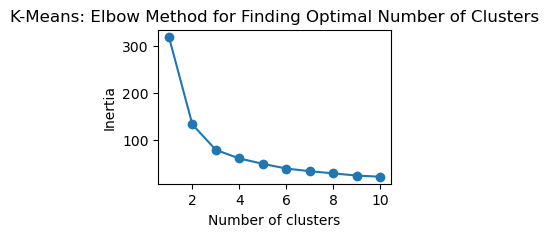

In [67]:
from sklearn.cluster import KMeans
import numpy as np

inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(features_df)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,11), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

kmeans labels:
[2 3 1 3 0 3 3 3 2 3 4 3 2 0 4 2 2 4 0 2 0 4 3 0 1 2 1 4 2 4 4 4 1 0 0 0 2
 2 2 0 3 1 4 0 0 4 3 2 4 2 1 3 4 0 1 4 0 2 0 3 2 0 2 3 1 0 2 2 2 1 2 4 2 2
 2 1 2 0 4 2]
pca explained variance ratio: [0.86847795 0.09978193]
pca components: 
                         PC1       PC2
res_mean            0.462439  0.773841
slope               0.523031 -0.274121
overall_depth      -0.494368  0.558459
overall_resistance  0.517870  0.118957


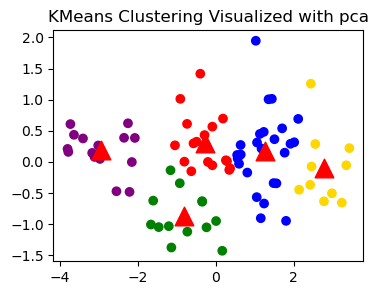

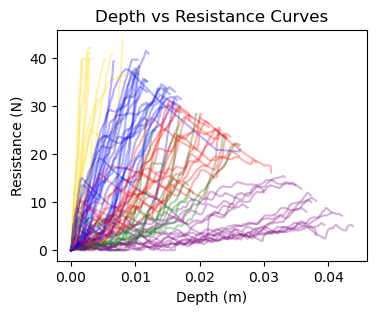

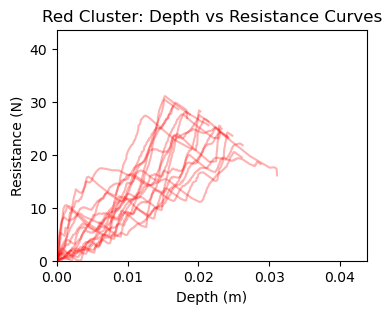

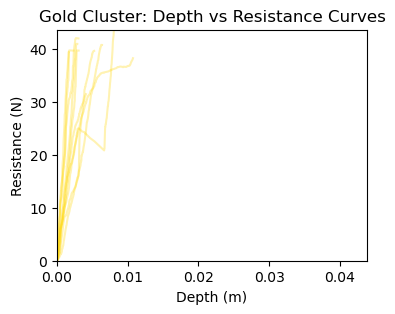

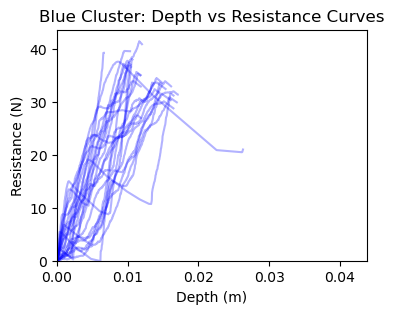

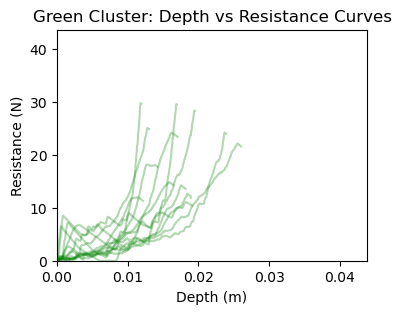

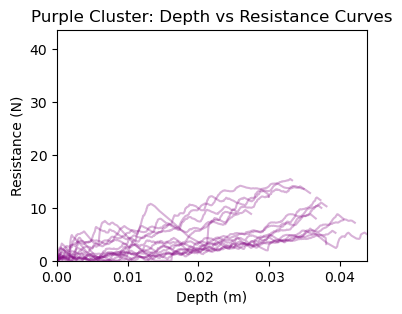

In [68]:
kmeans_elbow = 5
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(features_df)
print(f"kmeans labels:\n{kmeans.labels_}")
# print(f"kmeans cluster centers: {kmeans.cluster_centers_}")
visualize_clusters(features_df, kmeans.labels_, graph_title="KMeans", kmeans_centroids=kmeans.cluster_centers_, use_pca=True, two_d=False, overlay_plot=True, cluster_i_overlay=True)

# Hierarchical Clustering

[5 3 4 0 0 3 3 0 1 0 2 0 0 0 2 0 0 2 0 1 0 2 3 0 4 1 4 2 1 2 2 2 4 0 0 0 1
 1 1 0 3 4 2 0 0 2 0 0 2 1 4 0 2 0 1 2 0 1 0 3 0 0 0 0 4 0 5 1 1 1 5 2 1 5
 5 4 5 0 2 1]
pca explained variance ratio: [0.86847795 0.09978193]
pca components: 
                         PC1       PC2
res_mean            0.462439  0.773841
slope               0.523031 -0.274121
overall_depth      -0.494368  0.558459
overall_resistance  0.517870  0.118957


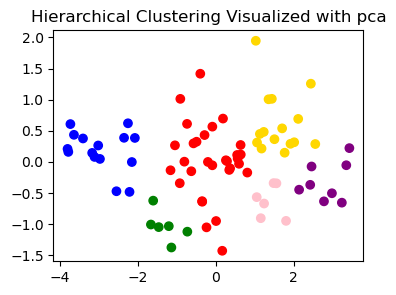

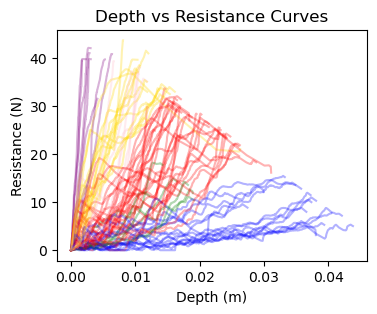

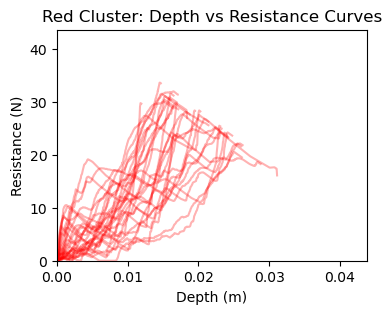

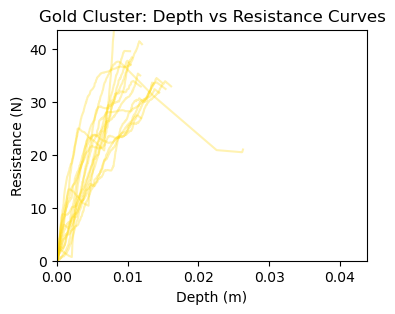

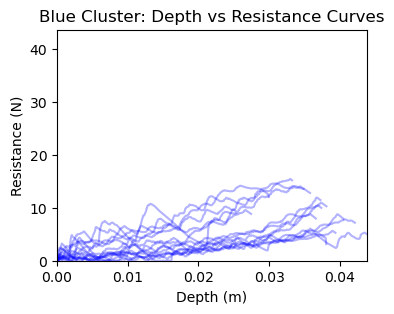

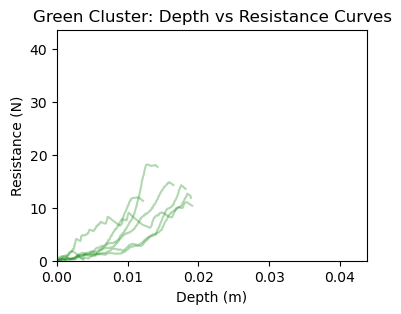

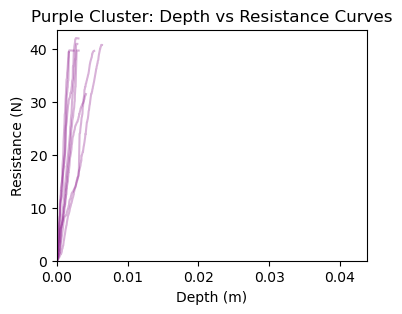

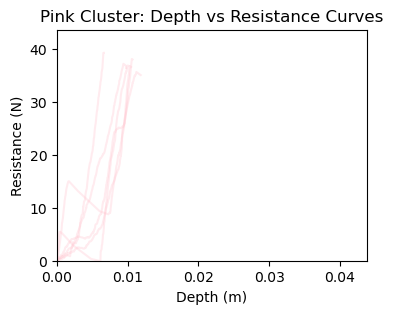

In [69]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=6)
hierarchical.fit(features_df)
linkage = "Ward"
print(hierarchical.labels_)
# get_curve_idx_from_cluster_color("green", hierarchical.labels_)
visualize_clusters(features_df, hierarchical.labels_, graph_title="Hierarchical", use_pca=True, overlay_plot=True, cluster_i_overlay=True)

# DBSCAN

[ 0  1  2  0  0  1 -1  3 -1  3  4 -1  0  0  4  0  0  5  0  6  0  5 -1  0
  7  6  8  5  6  9  4  4 -1  0  0  0  6  6 -1  0  1  8  9  0  0  4 10  0
  5 11  2  0  4  0  7  4  0  6  0  1  0 -1  0 10  2  0  0 11  6 -1  0  4
  6 -1  0  7  0  0  4  6]
Indexes of curves assigned to yellow cluster: 
resistance_depth_39.csv
resistance_depth_79.csv
pca explained variance ratio: [0.86847795 0.09978193]
pca components: 
                         PC1       PC2
res_mean            0.462439  0.773841
slope               0.523031 -0.274121
overall_depth      -0.494368  0.558459
overall_resistance  0.517870  0.118957


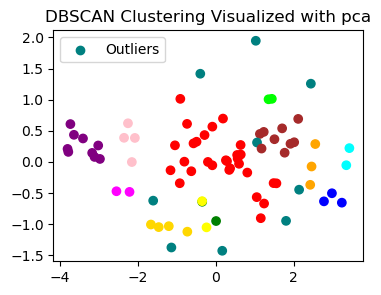

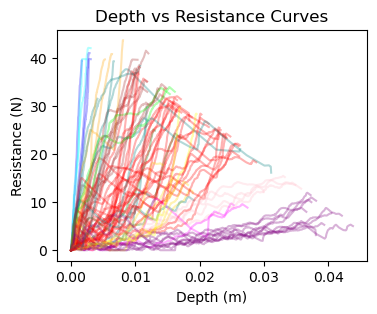

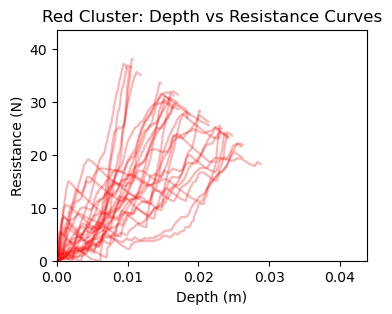

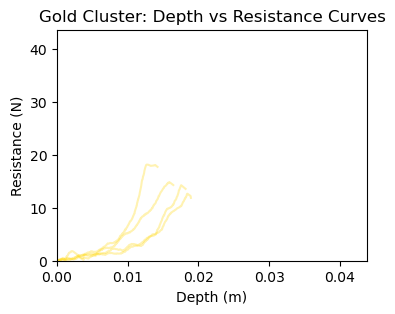

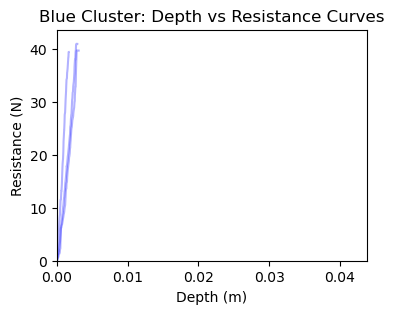

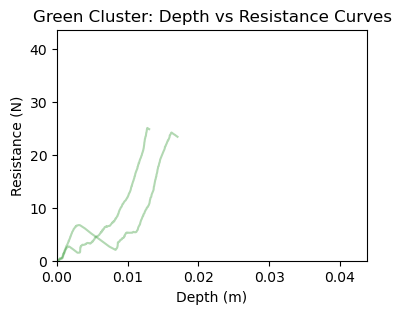

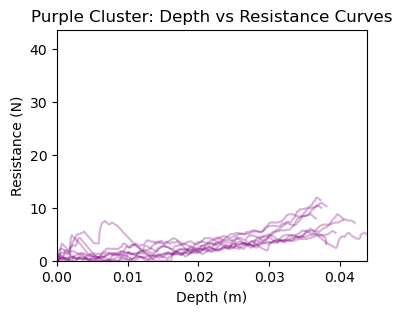

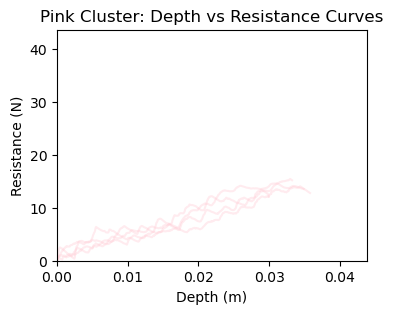

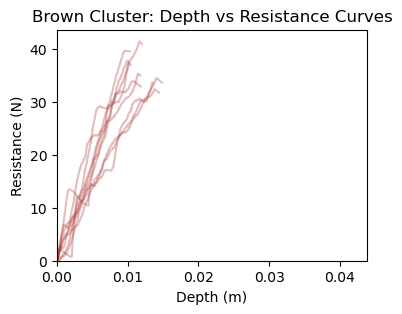

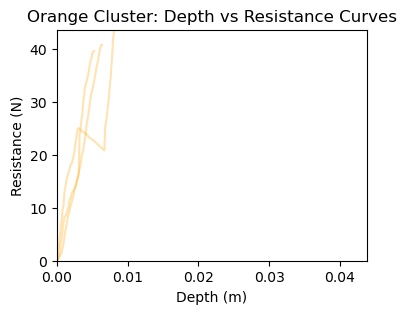

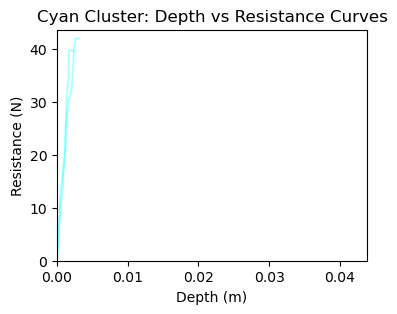

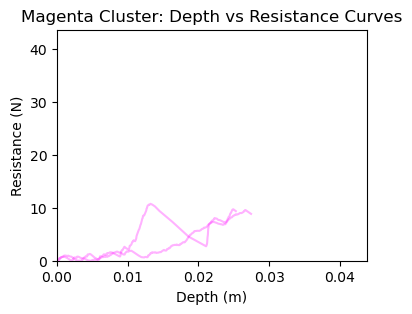

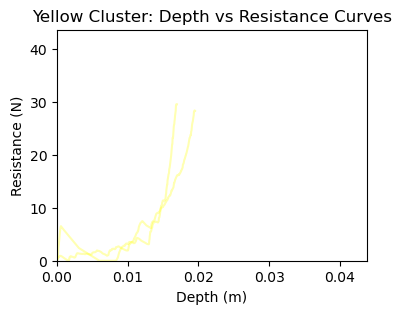

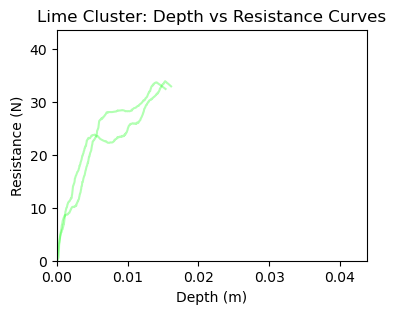

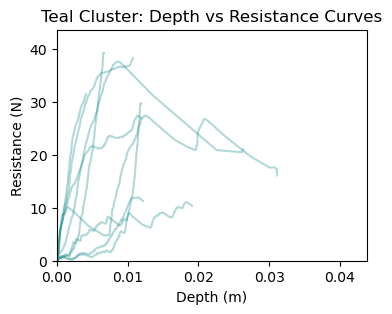

In [70]:
from sklearn.cluster import DBSCAN

# eps=0.7, min_samples=3 works very well
dbscan = DBSCAN(eps=0.5, min_samples=2).fit(features_df)
print(dbscan.labels_)
cleaned_db_labels = [label if label != -1 else max(dbscan.labels_)+1 for label in dbscan.labels_]
get_curve_idx_from_cluster_color("yellow", cleaned_db_labels)
visualize_clusters(features_df, y_labels = cleaned_db_labels, graph_title="DBSCAN", use_pca=True, overlay_plot=True, cluster_i_overlay=True)